## 0. Basic Packages

In [1]:
import pandas as pd
#Set copy warning to off
pd.set_option('mode.chained_assignment', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%store -r STOP_W_LIST
%store -r DF_INITIAL
%store -r REMOVE_ACCENTS
%store -r WORD_ROOT 
%store -r STOP_W 
%store -r VECTORIZER 
%store -r NGRAMS 

%store -r TOKENS 
%store -r TRANSFORMERS_PCKG 
%store -r MODEL 
%store -r CLUSTER_METHOD 

#cluster df
if CLUSTER_METHOD == "kmeans":
    %store -r TO_SCALE
    %store -r KMEANS_NCLUSTERS

else:
    %store -r HDBSCAN_CSIZE 


%store -r CLUSTER_DISTANCE 
%store -r WORDCLOUD_NGRAMS 

%store -r DENDROGRAM_DISTANCE
%store -r DENDROGRAM_P

%store -r SEARCH_TOPIC_COLUMNS
%store -r SEARCH_TOPIC_DIST 

##### We import all the functions used in the previous notebooks

In [3]:
from nlp_preprocess import *
from nlp_clustering import *

/home/diego/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)



##### We add accents to stop_words and exclude the words we want

In [4]:
from nltk.corpus import stopwords

#we select the spanish stop words (by default all the words with accents have them)
stop_words = stopwords.words('spanish')

#now we have the words with accents and the same ones without accents
stop_words = add_non_accents(stop_words)

#exclude previous list of words from stop_words
stop_words.difference_update(STOP_W_LIST)

## 1. Loading Initial Dataframe

This notebook will begin from the initial dataframe you selected in the previous notebook

That is, if you selected df_es, this will be the dataframe (the same with df_en)

In [5]:
DF_INITIAL

ID     Area                                            Comment  \
0       1   Dept 1  cerrar la brecha entre los que deciden el trab...   
1       3   Dept 1  sobretodo, que se miren las cargas de trabajo ...   
2       4   Dept 1  1. dar coaching a algunos gerentes (que no sab...   
3      19   Dept 1                                                  s   
4      29   Dept 1  mas oportunidades de crecimiento y major salar...   
..    ...      ...                                                ...   
287  2951  Dept 10  empresa enfocada en su recurso humano, con bue...   
288  2956  Dept 10  el conocer otros compañeros tanto de aqui como...   
289  2971  Dept 10  la empresa ha mantenido la estabilidad laboral...   
290  2989  Dept 10  la empresa brinda una estabilidad económica de...   
291  3000  Dept 10                                                 no   

    Initial_Classification language  
0                 Negativo       es  
1                 Negativo       es  
2                 Negativo       es  
3                 Negativo       es  
4                 Negativo       es  
..                     ...      ...  
287               Positivo       es  
288               Positivo       es  
289               Positivo       es  
290               Positivo       es  
291               Positivo       es  

[568 rows x 5 columns]

In [6]:
#function to clean comments of the dataset, dots, commas, accents, etc
#turn 'remove_accents' to 'no' if you want to keep words with accents (not recommended)
df_clean = clean_df(DF_INITIAL, remove_accents=REMOVE_ACCENTS)

#function to remove stop_words, make lemmatization and basic bigrams/trigrams
#turn 'root' to 'yes' if you want the lemma the of the word, 'stop_w' to 'yes' if you want to keep stop_words list
df_processed = preprocess_df(df_clean, root=WORD_ROOT, stop_w=STOP_W, stop_words=stop_words)

## 3. Vectorize

### Vectorize & make n-grams from comments

In [7]:
n1, n2 = int(NGRAMS.split(",")[0]), int(NGRAMS.split(",")[1])

In [8]:
#function to make grams from comments using 'CountVectorizer' or 'TfidfVectorizer'

#choose between both vectorizers, choose a tuple of grams, turn 'remove_accents' to 'no' if you want 
#words with accents (not recommended), and 'stop_w' to 'yes' if you want to include stop_words
df_vectorized = vectorizer_df(vectorizer=VECTORIZER, ngrams_range=(n1, n2), df=df_processed, remove_accents=REMOVE_ACCENTS, stop_w=STOP_W, stop_words=stop_words)
df_vectorized.id = df_vectorized.id.astype(int)

#### Merged df

In [9]:
#point to merge both dataframes a keep tracking the new grams with the original comments
df_merged = pd.merge(df_vectorized, df_processed, how="left", on=["id", "comment_type"])
print(df_merged.shape)
df_merged.head()

(5038, 8)


feature    id comment_type     score     area  \
0        _an_tiene  1724     Positivo  0.252462   Dept 9   
1  _anos_seguridad  1740     Positivo  0.229416   Dept 9   
2    _años_empresa   583     Positivo  0.182574   Dept 4   
3   _años_operando  2853     Positivo  0.333333  Dept 10   
4   _años_servicio   758     Positivo  0.230152   Dept 5   

                                             comment  \
0  es una organizacion solida se ha mantenido en ...   
1  mis padres se conocieron en el institucion. hi...   
2  llevo alrededor de 12 años en la empresa y tod...   
3  solidez en el mercado. no esperaría que cierre...   
4  compañia sólida. se preocupan por la salud y b...   

                                       clean_comment language  
0  organizacion solida mantenido favor consumidor...       es  
1  padres conocieron institucion hicieron familia...       es  
2  llevo alrededor años empresa años evaluaciones...       es  
3  solidez mercado no esperaria cierre operacione...       es  
4  compañia solida preocupan salud bienestar empl...       es

In [10]:
#code to show how the process is being done
df_merged[df_merged.duplicated(subset=["feature"], keep=False)].sort_values(by=["feature", "id", "comment"]).head(15)

feature    id comment_type     score    area  \
210   analytics_development_program   428     Positivo  0.316757  Dept 4   
211   analytics_development_program   469     Negativo  0.146828  Dept 4   
438            balance_trabajo_vida  1093     Negativo  0.200960  Dept 7   
439            balance_trabajo_vida  1321     Negativo  0.170086  Dept 8   
440           balance_vida_personal   421     Positivo  0.465730  Dept 4   
441           balance_vida_personal   899     Negativo  0.139800  Dept 5   
442           balance_vida_personal  1345     Negativo  0.345592  Dept 8   
443            balance_vida_trabajo   143     Negativo  0.188519  Dept 1   
444            balance_vida_trabajo   195     Negativo  0.241698  Dept 1   
445            balance_vida_trabajo  1070     Negativo  0.049752  Dept 7   
446            balance_vida_trabajo  1321     Negativo  0.155770  Dept 8   
482  beneficios_estabilidad_laboral  1721     Positivo  0.683892  Dept 9   
483  beneficios_estabilidad_laboral  2642     Positivo  0.424387  Dept 9   
503          beneficios_plan_medico   540     Positivo  0.340737  Dept 4   
504          beneficios_plan_medico  1081     Positivo  0.683892  Dept 7   

                                               comment  \
210  oportunidades de desarrollo como lean academy,...   
211  reforzaria las areas de liderazgo estrategico,...   
438  mantendria la flexibilidad de trabajar remoto ...   
439  me encanta el lugar que trabajo, me gusta trab...   
440  balance entre vida personal y trabajo. buenos ...   
441  1) la distancia que existe entre gerentes/supe...   
442  salarios más competitivos (a nivel de mercado)...   
443  promover el balance vida/trabajo (mas alla de ...   
444  continuar fomentando el balance de vida y trab...   
445  compensación, redistribución de tareas, cambio...   
446  me encanta el lugar que trabajo, me gusta trab...   
482          * buenos beneficios * estabilidad laboral   
483  beneficios, estabilidad laboral que se lo da s...   
503  edificio es comodo y tiene buenos beneficios c...   
504                   beneficios (plan medico, profit)   

                                         clean_comment language  
210  oportunidades desarrollo lean academy project ...       es  
211  reforzaria areas liderazgo estrategico intelig...       es  
438  mantendria flexibilidad trabajar remoto opcion...       es  
439  encanta lugar trabajo gusta trabajar unidad no...       es  
440    balance vida personal trabajo buenos beneficios       es  
441  distancia existe empleados estilo gerencial ar...       es  
442  salarios competitivos nivel mercado mayor bala...       es  
443  promover balance alla mencionarlo concrete muc...       es  
444  continuar fomentando balance vida trabajo prog...       es  
445  compensacion redistribucion tareas cambio gene...       es  
446  encanta lugar trabajo gusta trabajar unidad no...       es  
482              buenos beneficios estabilidad laboral       es  
483  beneficios estabilidad laboral da posicionamie...       es  
503  edificio comodo tiene buenos beneficios plan_m...       es  
504                      beneficios plan_medico profit       es

### 4. Clustering

##### Multilingual models able to use directly from sentence_transformers

In [11]:
#'distiluse-base-multilingual-cased' is the model recommended for ES by sentence_transformes

st_models = ["distiluse-base-multilingual-cased", "distiluse-base-multilingual-cased-v2",
            "paraphrase-xlm-r-multilingual-v1", "stsb-xlm-r-multilingual", "quora-distilbert-multilingual",
            "distilbert-multilingual-nli-stsb-quora-ranking", "xlm-r-100langs-bert-base-nli-stsb-mean-tokens"]

##### Multilingual models pre-trained from transformers library (this is the way to use them)

In [12]:
hf_models = ["bert", "distilbert"]

##### Cluster function


----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
Top 10 Explained Variance Variables by percentage
 [0.05349935 0.0370893  0.03184816 0.02831333 0.02349779 0.02245767
 0.02079449 0.01998818 0.01861408 0.01815395] 

Explained Variance by Percentage with the 3 components selected [0.05349943 0.03708925 0.03184795] 


----------------------------------------------------------------------------------------------------------
(4988, 5)
                        comments  clusters         x         y         z
0   interno_comunicacion_niveles         3 -1.265399 -4.699705  0.780588
1          directa_respuestas_no         1 -7.267973  4.851850 -1.589061
2  razon_suficiente_considererlo         9 -6.946230  0.934606  2.163578
3          unidad_actualmente_no         1 -6.467769  2.455079 -3.666789
4         mayor_grado_honestidad   

----------------------------------------------------------------------------------------------------------
Getting Wordcloud


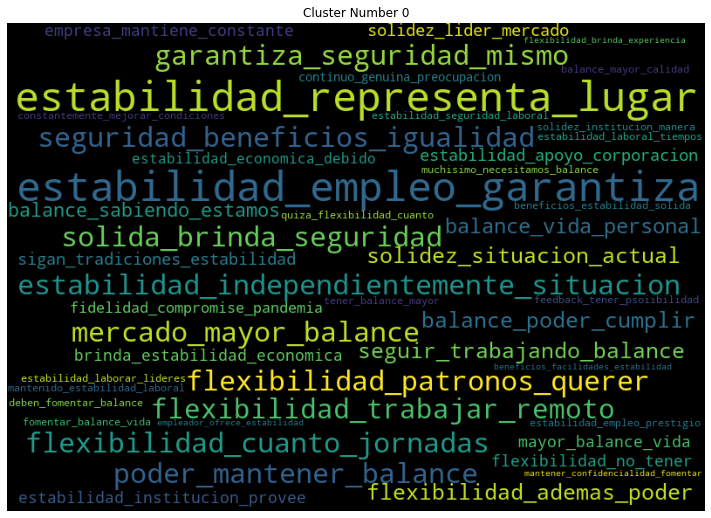

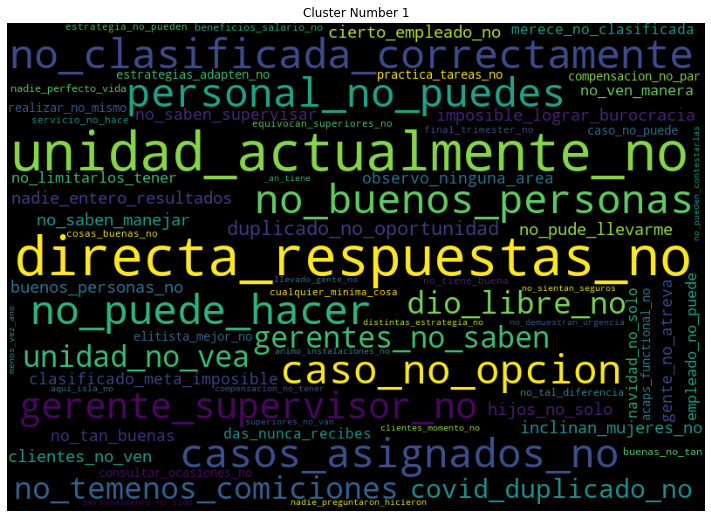

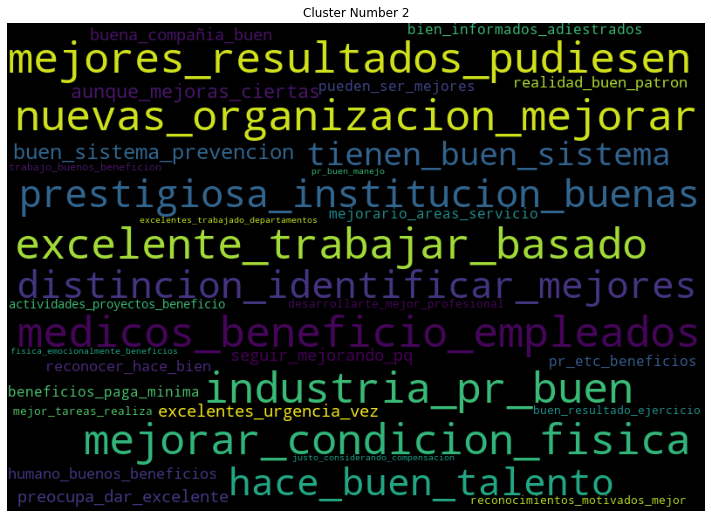

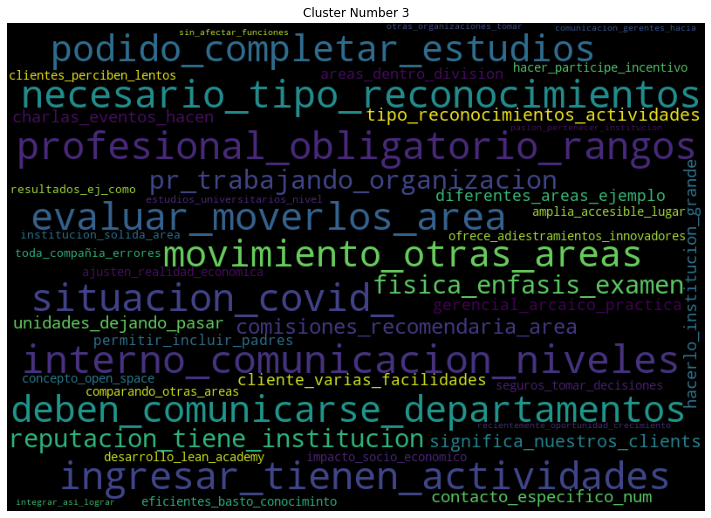

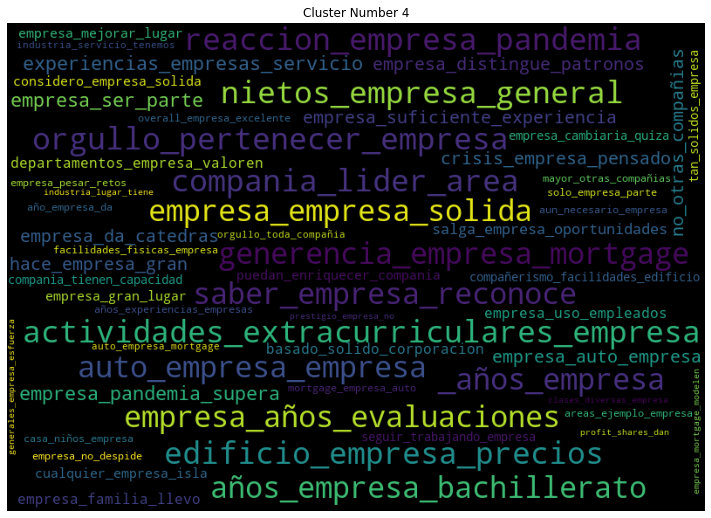

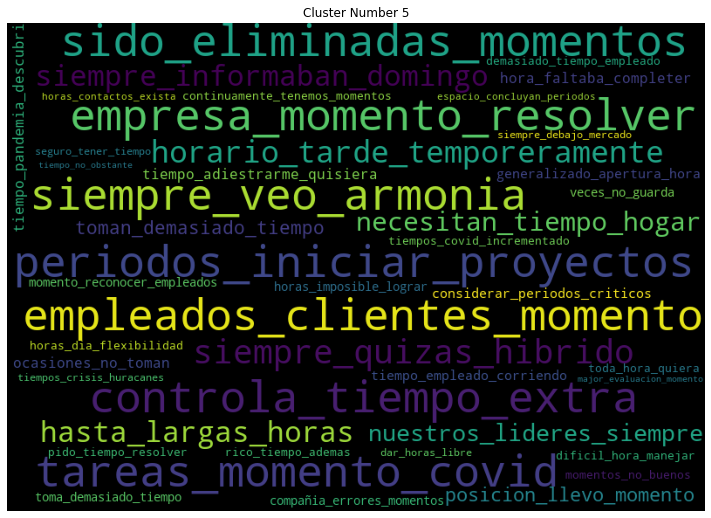

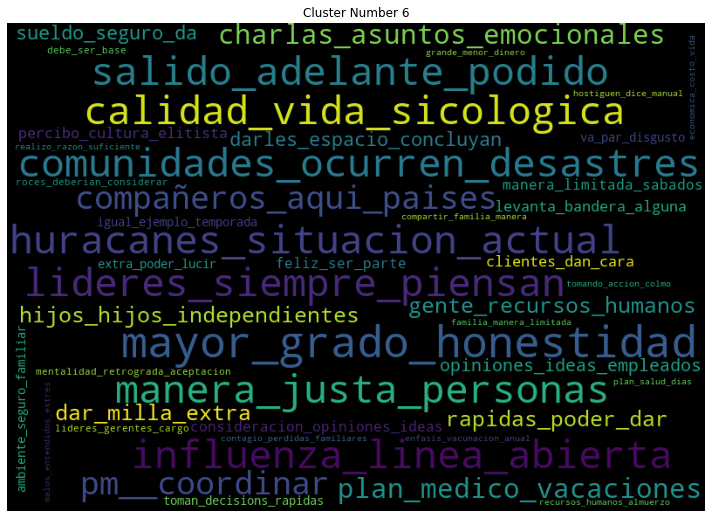

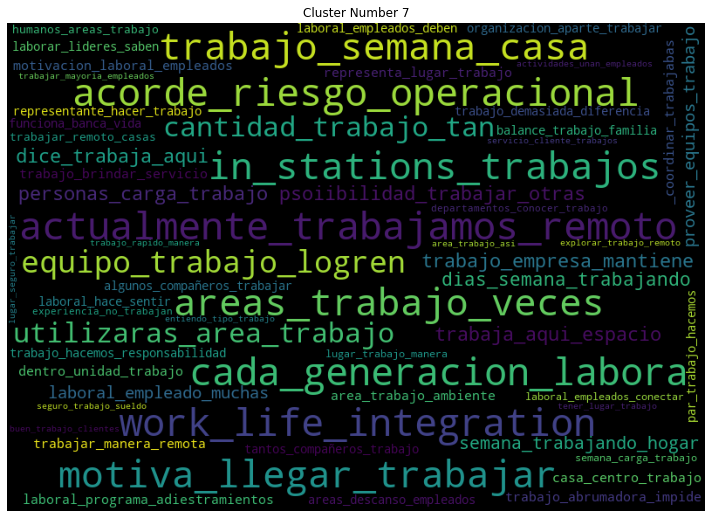

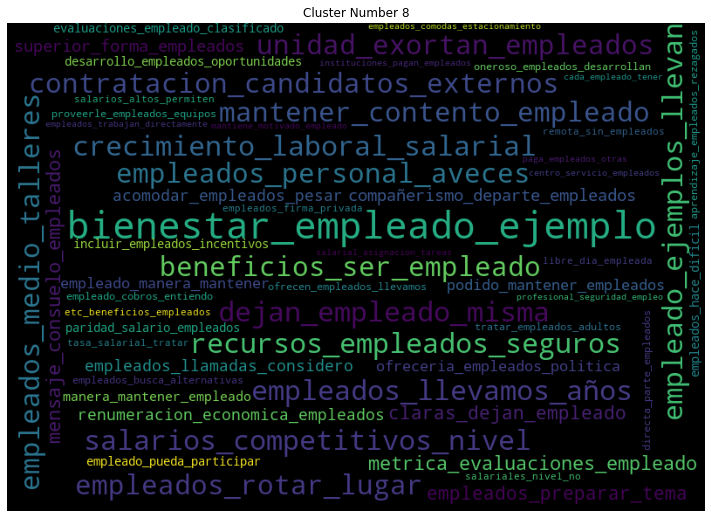

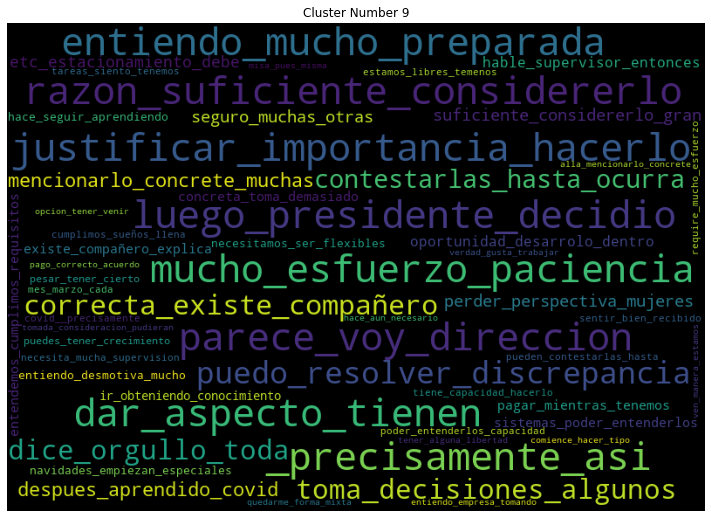

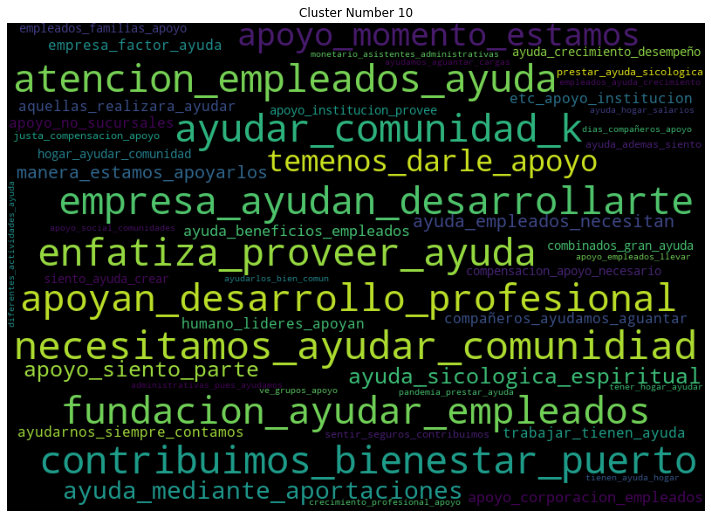

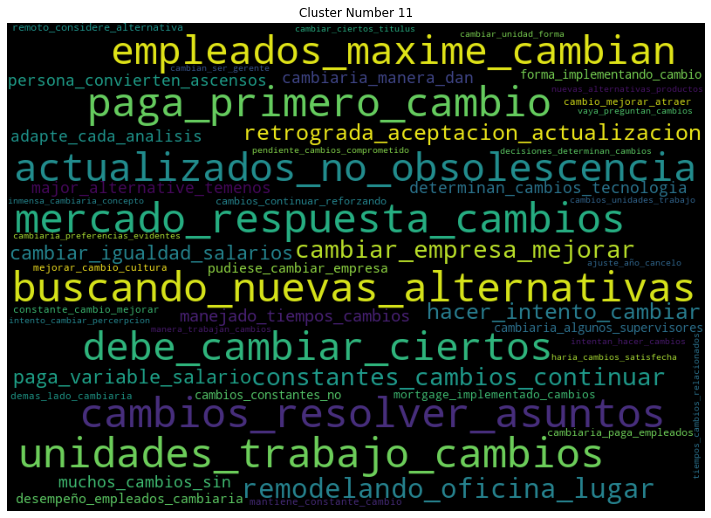

In [13]:
df_tokens = tokens_selection(df_merged, element=TOKENS)
print("\n")

if CLUSTER_METHOD == "kmeans":
    df_clusterized = clusterize_fixed(model=MODEL, cluster_method=CLUSTER_METHOD, comments=df_tokens, d_metric=CLUSTER_DISTANCE, scale=TO_SCALE, k=KMEANS_NCLUSTERS, min_cluster_size=None, grams=WORDCLOUD_NGRAMS)

else:
    df_clusterized = clusterize_fixed(model=MODEL, cluster_method=CLUSTER_METHOD, comments=df_tokens, d_metric=CLUSTER_DISTANCE, scale=None, k=None, min_cluster_size=HDBSCAN_CSIZE, grams=WORDCLOUD_NGRAMS)

In [14]:
print(df_clusterized.shape)
df_clusterized.head()

(4988, 2)


comments  clusters
0   interno_comunicacion_niveles         3
1          directa_respuestas_no         1
2  razon_suficiente_considererlo         9
3          unidad_actualmente_no         1
4         mayor_grado_honestidad         6

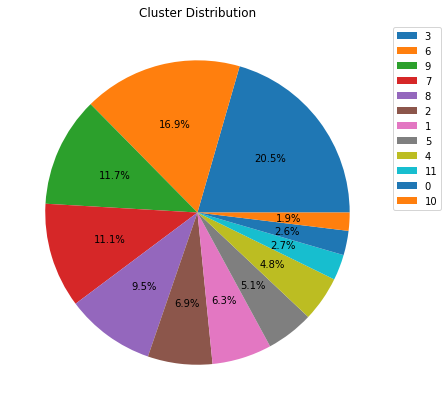

In [15]:
#frequency 'pie' or 'bar'
show_cluster_freq(df_clusterized, "pie")

## 5. Dendrogram

Getting Dendrogram


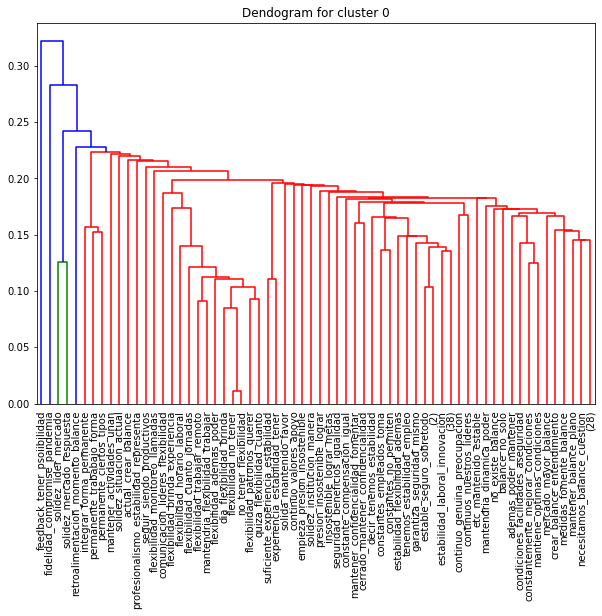

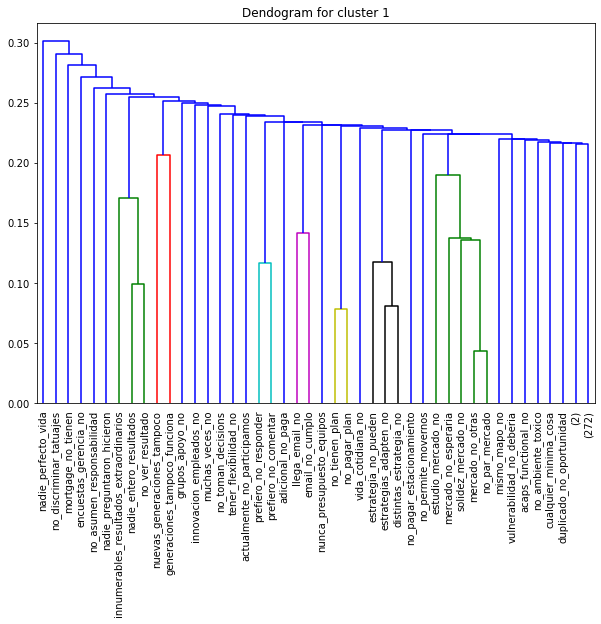

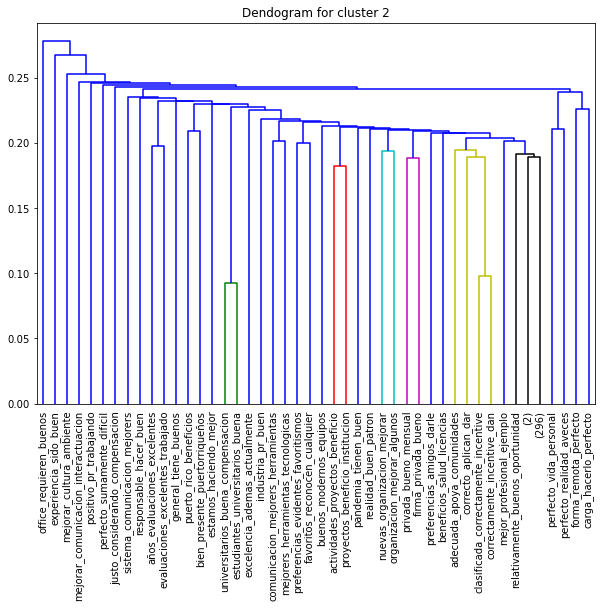

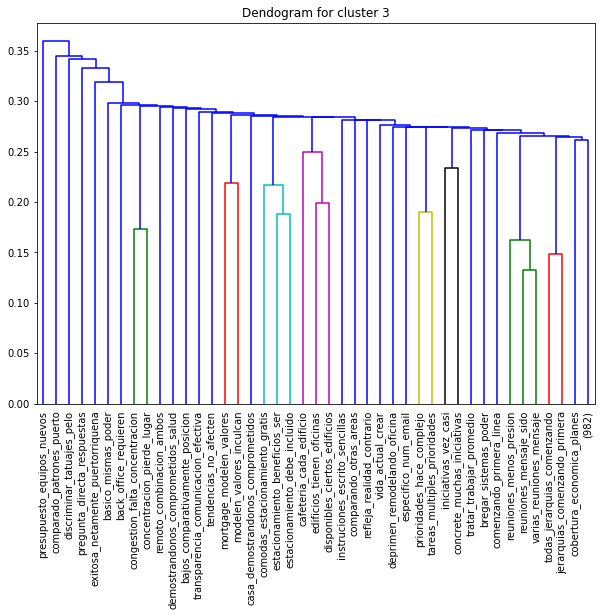

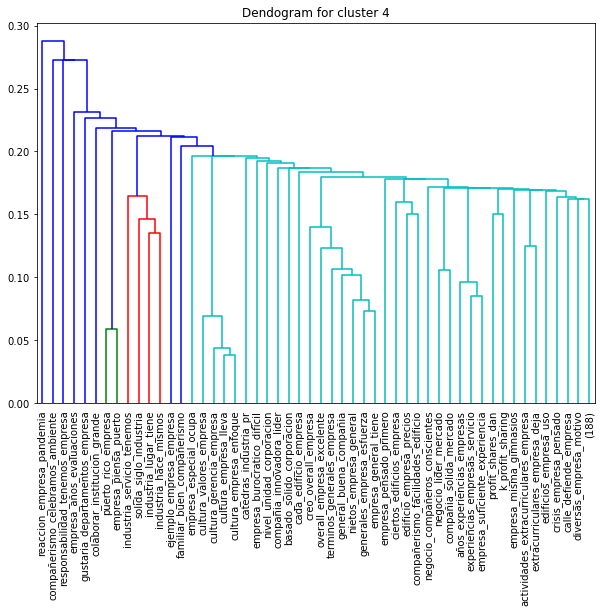

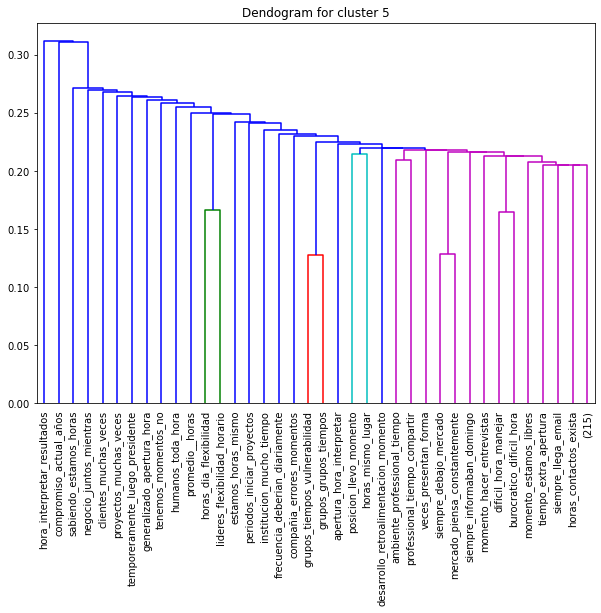

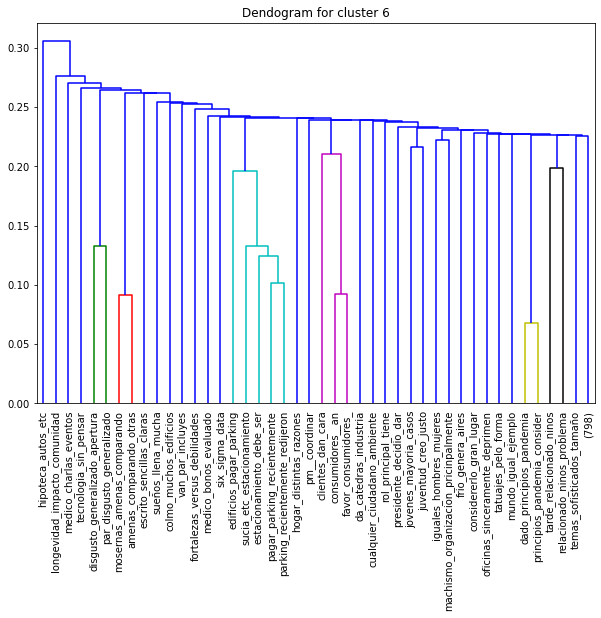

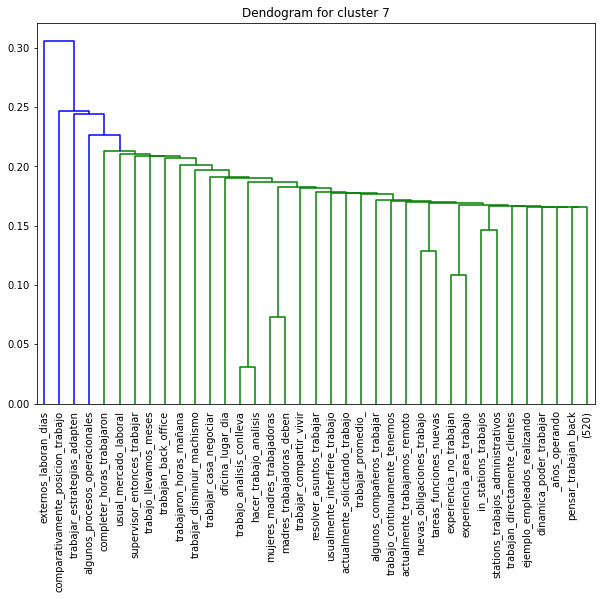

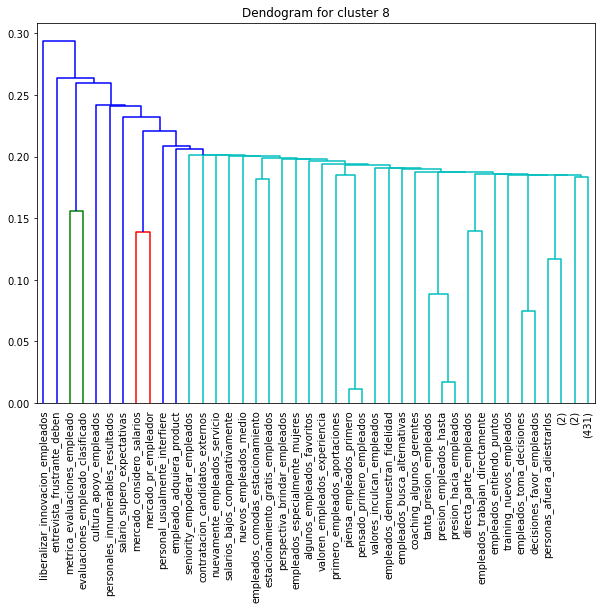

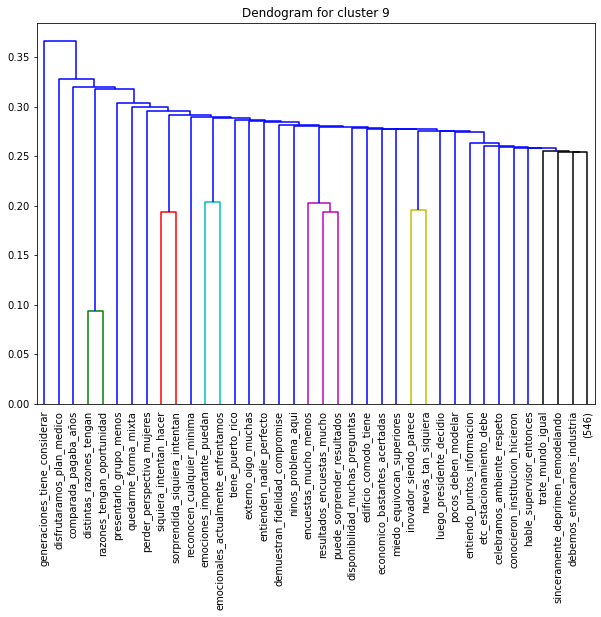

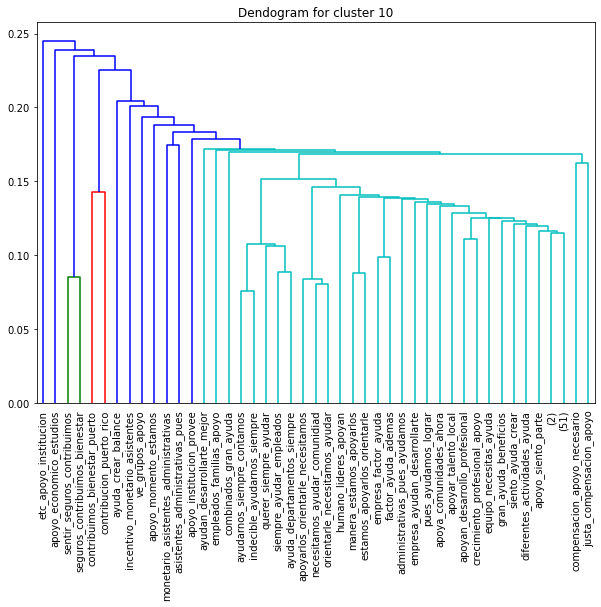

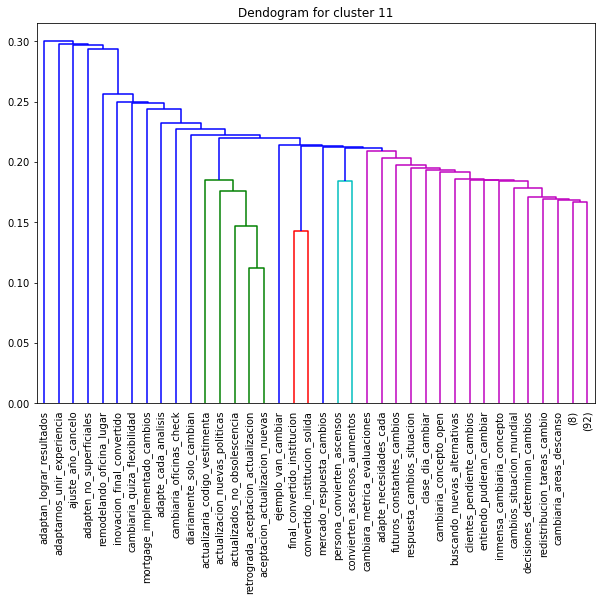

In [16]:
print("Getting Dendrogram")

for i in list(set(df_clusterized.clusters)):
    comments = list(df_clusterized.comments[df_clusterized.clusters==i])
    
    if MODEL in st_models:
        to_use_vecs = st_vectorize(comments=comments, model=MODEL)
    
    elif MODEL in hf_models:
        to_use_vecs = hf_vectorize(comments=comments, model=MODEL)
        
    get_dendrogram(vecs=to_use_vecs, metric=DENDROGRAM_DISTANCE, p=DENDROGRAM_P, labels=comments, i=i)

## 6. Final Dataframe & Search Topic

In [17]:
df_final = final_df_selection(df1=df_merged, df2=df_clusterized, element=TOKENS)

print(df_final.shape)
df_final.head()

(5038, 9)


feature    id comment_type     score     area  \
0        _an_tiene  1724     Positivo  0.252462   Dept 9   
1  _anos_seguridad  1740     Positivo  0.229416   Dept 9   
2    _años_empresa   583     Positivo  0.182574   Dept 4   
3   _años_operando  2853     Positivo  0.333333  Dept 10   
4   _años_servicio   758     Positivo  0.230152   Dept 5   

                                             comment  \
0  es una organizacion solida se ha mantenido en ...   
1  mis padres se conocieron en el institucion. hi...   
2  llevo alrededor de 12 años en la empresa y tod...   
3  solidez en el mercado. no esperaría que cierre...   
4  compañia sólida. se preocupan por la salud y b...   

                                       clean_comment language  clusters  
0  organizacion solida mantenido favor consumidor...       es         1  
1  padres conocieron institucion hicieron familia...       es         6  
2  llevo alrededor años empresa años evaluaciones...       es         4  
3  solidez mercado no esperaria cierre operacione...       es         7  
4  compañia solida preocupan salud bienestar empl...       es         6

In [18]:
topics = list(*[t.split(", ") for t in [input("Please input a topic/s to search most similar comments in dataframe\nThe topics must be separated a comma and space\nEx 1 topic: informacion\nEx list of topics: informacion, comunicacion, lideres\n")]])
print("\n")


if MODEL in st_models:
    vectorized_t = st_vectorize(comments=topics, model=MODEL)
    
    if re.search("ngrams", TOKENS):
        vectors = st_vectorize(comments=list(df_final.feature), model=MODEL)
    else:
        vectors = st_vectorize(comments=list(df_final.clean_comment), model=MODEL)
        
elif MODEL in hf_models:
    vectorized_t = hf_vectorize(comments=topics, model=MODEL)
    
    if re.search("ngrams", TOKENS):
        vectors = hf_vectorize(comments=list(df_final.feature), model=MODEL)
    else:
        vectors = hf_vectorize(comments=list(df_final.clean_comment), model=MODEL)  
    
    
df_final["vectors"] = [v for v in vectors]

top_results = int(input("Please write the number of top comments per topic you want in the df:\n"))
        
df_topic = search_by_topic(df=df_final, top_results=top_results, columns=SEARCH_TOPIC_COLUMNS, dist=SEARCH_TOPIC_DIST, vectors=vectorized_t, topics=topics)

Please input a topic/s to search most similar comments in dataframe
The topics must be separated a comma and space
Ex 1 topic: informacion
Ex list of topics: informacion, comunicacion, lideres
informacion, comunicacion, lideres





Please write the number of top comments per topic you want in the df:
20


In [19]:
df_topic.head()

id    area                                            comment  \
2746  1081  Dept 7  mejorar la comunicacion, interactuacion de var...   
2761  1070  Dept 7  compensación, redistribución de tareas, cambio...   
2749  1472  Dept 9       buena comunicacion entre lideres y empleados   
2743   699  Dept 4  comunicacion de los gerentes hacia los empleados.   
2740  2200  Dept 9  que la comunicacion entre la gerencia intermed...   

             topic  
2746  comunicacion  
2761  comunicacion  
2749  comunicacion  
2743  comunicacion  
2740  comunicacion

In [20]:
df_topic.tail()

id    area                                            comment  \
13478  2574  Dept 9  actualmente la empresa mortgage ha implementad...   
7940    944  Dept 6  los mejores beneficios. tienen empatía, son so...   
7934   1477  Dept 9  si pudiera cambiar algo de mi unidad, seria la...   
13469  2342  Dept 9  cambiaria algunos supervisores y jefes de otra...   
13475  1025  Dept 6  cambiaria el que los supervisors y gerentes no...   

         topic  
13478  lideres  
7940   lideres  
7934   lideres  
13469  lideres  
13475  lideres

In [21]:
topic_name = ("_".join(topics)).replace(" ", "_")
df_topic.to_csv(f"df_topic_final_{topic_name}.csv", index=False)